# Multivariate regression to predict the wind speed field

In [9]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from data_loaders import get_wake_dataloader

In [10]:
DATAFRAME_FILEPATH = "data/wake_dataframe.csv"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# hyperparameters
BATCH_SIZE = 8
EPOCHS = 500
LR = 0.00001

In [11]:
INPUT_VARIABLES = ['ws', 'TI', 'ct']
OUTPUT_VARIABLES = ["WS_eff", "TI_eff", "P"]

#TODO split in training and test sets
train_dataloader = get_wake_dataloader(DATAFRAME_FILEPATH, INPUT_VARIABLES, OUTPUT_VARIABLES, MinMaxScaler(), BATCH_SIZE)
len(train_dataloader)

/Users/niccolomorabito/Library/CloudStorage/GoogleDrive-morabito.1808746@studenti.uniroma1.it/My Drive/BDMA/Semester4 Thesis/Ainslie-surrogate/data_loaders.py:45: UserWarning: Currently, only one output feature (WS_eff) is considered in multivariate setting, the others are ignored
  warnings.warn("Currently, only one output feature (WS_eff) is considered in multivariate setting, the others are ignored") #TODO


2

In [ ]:
input_space = len(INPUT_VARIABLES) # or train_dataloader.dataset.x.shape[1]
output_space = train_dataloader.dataset.y.shape[1]

model = nn.Sequential(
    nn.Linear(input_space, 50),
    nn.ReLU(),
    nn.Linear(50, 500),
    nn.ReLU(),
    nn.Linear(500, output_space),
    nn.ReLU() #TODO?
).to(DEVICE)

def MSE(y_predicted:torch.Tensor, y_target:torch.Tensor):
    """
    Returns a single value tensor with 
    the mean of squared errors (SSE) between the predicted and target
    values:
    
    """
    error = y_predicted - y_target # element-wise substraction
    return torch.sum(error**2 ) / error.numel() # mean (sum/n)

def mean_speed_error(y_predicted:torch.Tensor, y_target:torch.Tensor):
    error = y_predicted - y_target
    return torch.mean(error, 1)

optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=LR
)
model.train()

print("Starting training")
epoch_to_loss_acc = dict()
max_accuracy = 0
for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accs = torch.FloatTensor()
    for batch in iter(train_dataloader):
        #TODO to device in the dataloader
        input_features, WS_eff_output = batch

        prediction = model.forward(input_features)

        # loss and step
        loss = MSE(prediction, WS_eff_output)
        #optimizer.zero_grad() TODO
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_loss += loss.item()

        #TODO accuracy or other metric computation
        acc = mean_speed_error(prediction, WS_eff_output)
        epoch_accs = torch.cat((epoch_accs, acc))

    epoch_acc = torch.mean(epoch_accs).item()
    print(f"{epoch=} -> {epoch_loss=}\t{epoch_acc=}")
    epoch_to_loss_acc[epoch] = [epoch_loss, epoch_acc]

#epoch_to_loss_acc

<AxesSubplot: xlabel='Epoch'>

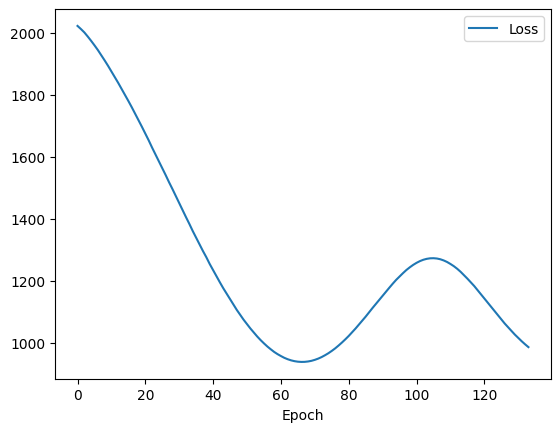

In [ ]:
metrics_df = pd.DataFrame(epoch_to_loss_acc).transpose().reset_index().rename(columns={"index": "Epoch", 0: "Loss", 1: "Speed avg error in wake prediction"})
metrics_df.plot(x="Epoch", y="Loss")

<AxesSubplot: xlabel='Epoch'>

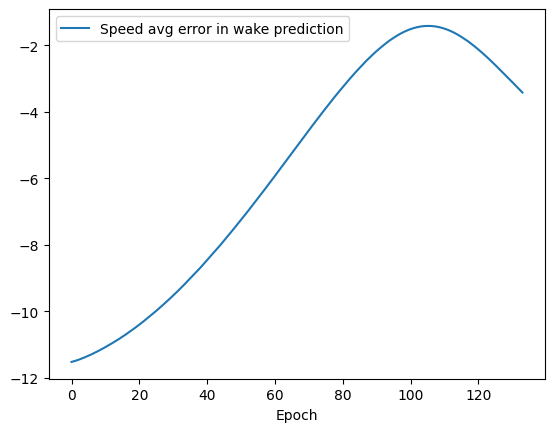

In [ ]:
metrics_df.plot(x="Epoch", y="Speed avg error in wake prediction")